<font size="5">Variational Bayes unsupervised time series clustering</font>

In variational inference applied to time series data, we choose M clusters each with distinct parameters allowing computation of a likelihood function for any time step. The likelihood function output given the empirical data observed at any time step varies depending on our chosen parameters for each of the M clusters that any time step may fall into. The model optimizes the parameters of the M clusters to maximize the likelihood of those parameters given the data.

In practice this works out to function as an unsupervised classification algorithm for the most likely distribution (mean and covariance) a time step comes from. This is applicable to discovering market regimes in quantitative finance. This notebook is purely an exercise in demonstration of scikit-learn's Bayesian optimization capabilities in this setting. 

In [14]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

I will be testing with a small asset universe of the 10Y Treasury ETF, a Commodity basket ETF, and Tech sector ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent states describing mean and covariance within a cluster. These latent states are the result of optimization using expectation maximization with a dirichlet process mixture model. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [15]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [16]:
m6 = pd.read_csv('./data/assets.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Lebesgue Integral</font>

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). 1st-order differencing of the 9-day rolling mean log price for each asset. This is essentially tracking a rolling integral within a bounded moving window or, equivalently, the expectation of the random variable log price over a smoothed out window. This captures the auto-correlation structure of the time series which I then visualize. 

This clusters the data into regions where the mean, or expectation of return, is shifting in some significant way and preserves long memory. 

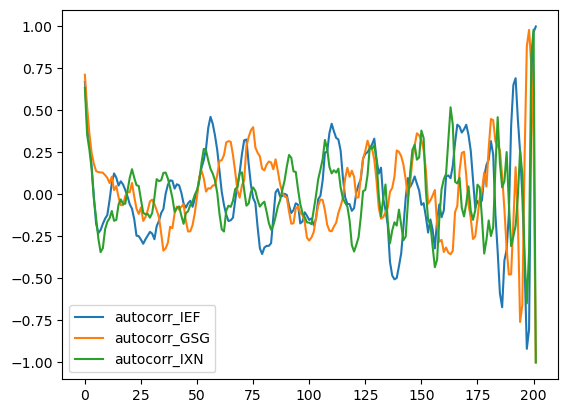

In [17]:
m6_subset = m6_assets.copy()
# First convert to log price and produce rolling mean window
m6_subset = m6_subset.apply(np.log).rolling(9).mean()
# Then apply final 1st-order differencing to get a rate-of-change
m6_subset = m6_subset.apply(np.diff).dropna().reset_index().drop(columns='index')

# View Auto Correlation
autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(1, len(autocorr_df)-1)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(1, len(autocorr_df)-1)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(1, len(autocorr_df)-1)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the most frequently occuring latent state discovered using np.argmax(). 

In [18]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')

In [19]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

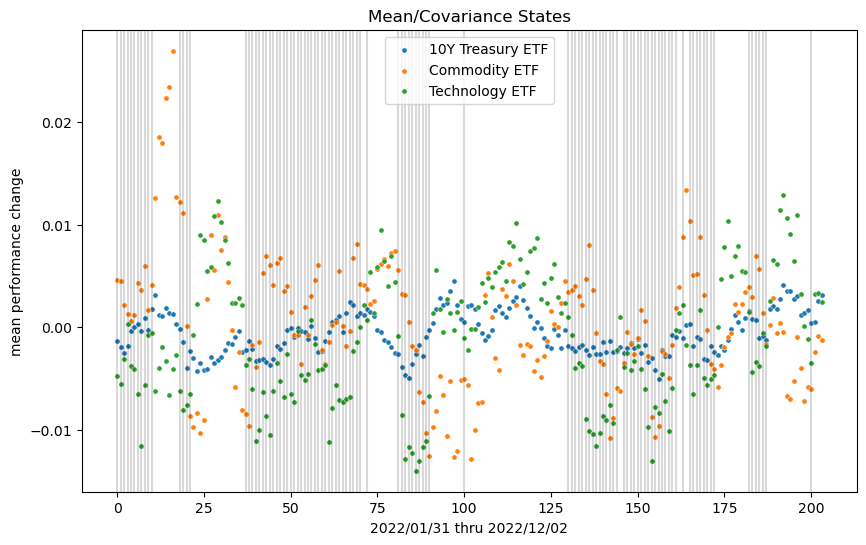

In [20]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.scatterplot(data=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF', s=14)
sns.scatterplot(data=m6_subset['GSG'], ax=ax, label='Commodity ETF', s=14)
sns.scatterplot(data=m6_subset['IXN'], ax=ax, label='Technology ETF', s=14)

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean/Covariance States')
ax.set_ylabel('mean performance change')
ax.set_xlabel(f'2022/01/31 thru 2022/12/02')
plt.show()

In [21]:
print(dpgmm_model.means_[:10])

[[-0.00060393  0.00045371 -0.00099054]
 [-0.00060391  0.00045366 -0.00099056]
 [-0.00060389  0.00045362 -0.00099057]
 [-0.00060387  0.00045357 -0.00099059]
 [ 0.00082284  0.01382902 -0.00344807]
 [-0.00060383  0.00045348 -0.00099062]
 [-0.00060381  0.00045343 -0.00099063]
 [-0.00060379  0.00045338 -0.00099065]
 [-0.00060377  0.00045334 -0.00099066]
 [-0.00060375  0.00045329 -0.00099068]]
